In [1]:
import numpy as np
import math
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import scipy.integrate as integrate
import scipy.optimize 


import argparse
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import gridspec
import glob
import sys
import h5py
import cmasher as cmr
from skimage import measure
import scipy.integrate
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.patheffects as pe
import matplotlib.ticker as mticker
import matplotlib.patheffects as path_effects

matplotlib.rc('font', family='sans-serif', size=12)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['lines.dash_capstyle'] = 'round'
matplotlib.rcParams['lines.solid_capstyle'] = 'round'
matplotlib.rcParams['figure.dpi'] = 200
cycle=plt.rcParams['axes.prop_cycle'].by_key()['color']


import glob
import h5py
import re
from scipy import interpolate
from scipy import optimize
from scipy import integrate
from matplotlib import rc
from matplotlib import cm

rc('text', usetex=True)

import cmasher as cmr


In [3]:
# enter the desired value of the hot phase temperature (in Kelvin) here, the fiducial value is 1e6 K
T_hot_in_K = 1e6

gamma               = 5.0/3.0 


# read in data for the real cooling curve.
# here we are using the real cooling curve at a pressure of p/kb=1000. 
# The real cooling curve is basically independent on pressure in the range of pressure we are interested in
data = np.load('edot_P1e3.data.npz')
Ts  =   data['Ts']
edot_P1e3   =   data['edot_P1e3']
P   =   data['P']

from scipy import interpolate
f_edot = interpolate.interp1d(Ts, edot_P1e3, bounds_error=False,fill_value=0)
# interpolate between the real cooling curve to get a function that returns the value of edot_cool
# take the value of T_hot we chose before and set that temperature to be at thermal equilibrium (Edot_cool=Edot_heat)
# assuming that Edot_heat is a constant, this setup also gives us the cold equilibrium temperature
epsilon_T = 0.05
def edot_cool_double_equilibrium(T):
    Edot_heat = f_edot(T_hot_in_K)
    Edot_cool = f_edot(T_hot_in_K*T)
    Edot_heat *= np.where(T<(1+epsilon_T), 1, (T/(1+epsilon_T))**(-5))
    return 1.5/tau*(Edot_cool-Edot_heat)

edot_cool_double_equilibrium = np.vectorize(edot_cool_double_equilibrium)


# define functions that return values of vx and its 1st & 2nd derivatives 
# remember that we are taking the vx profile as a cosine
def vx_cos(z):
    if (z > h):
        return 0
    else:
        return (mach_rel/2)*(np.cos(np.pi*z/h)+1)

vx_cos = np.vectorize(vx_cos)    
    
def dvx_dz_cos(z):
    if (z > h):
        return 0
    else:
        return -(mach_rel/2) * np.pi/h * np.sin(np.pi*z/h)

dvx_dz_cos = np.vectorize(dvx_dz_cos)
    
def d2vx_dz2_cos(z):
    if (z > h):
        return 0
    else:
        return -(mach_rel/2) * (np.pi/h)**2 * np.cos(np.pi*z/h)

d2vx_dz2_cos = np.vectorize(d2vx_dz2_cos)


# define an integrator that will later be taken as an input to scipy's solve_ivp function.
# we are solving 4 coupled differential equations (1st & 2nd derivatives of T and vz), so we need expressions of those as outputs of the integrator function
def integrator(z, w, mdot): 
    dT_dz, T, dvz_dz, vz = w
    if (z <= 0):
        dvx_dz = 0
        d2vx_dz2 =0 
    elif (z > h):
        dvx_dz = 0
        d2vx_dz2 =0 
    else:
        dvx_dz = -(mach_rel/2) * np.pi/h * np.sin(np.pi*z/h)
        d2vx_dz2 = -(mach_rel/2) * (np.pi/h)**2 * np.cos(np.pi*z/h)

    if (T <= T_peak):
        pressure = T * mdot / vz
        edot_cool = 1.5 * P_hot/tau * (pressure/P_hot)**2 * ((T/T_peak)**-beta_lo - heating_coefficient*(T/T_peak)**alpha_heat)
    elif (T > T_peak):
        pressure = T * mdot / vz
        edot_cool = 1.5 * P_hot/tau * (pressure/P_hot)**2 * ((T/T_peak)**-beta_hi - heating_coefficient*(T/T_peak)**alpha_heat)

    # the derivation of these equations can be found in the methods section of the paper
    kappa        = (mdot/vz) * (f_nu * h**2 * np.abs(dvx_dz) + kappa_0 / (mdot/vz))
    mu        = Prandtl * (mdot/vz) * (f_nu * h**2 * np.abs(dvx_dz) + kappa_0 / (mdot/vz))
    dkappa_dz       = f_nu * h**2 * ((mdot/vz) * d2vx_dz2 - (mdot/vz**2) * np.abs(dvx_dz) * dvz_dz)
    dmu_dz       = Prandtl * (f_nu * h**2 * ((mdot/vz) * d2vx_dz2 - (mdot/vz**2) * np.abs(dvx_dz) * dvz_dz))
    d2T_dz2     = edot_cool_double_equilibrium(T)/kappa + mdot*vz/kappa * (T/vz**2 * dvz_dz + dT_dz/(gamma-1)/vz) - dT_dz * dkappa_dz/kappa - mu/kappa * (dvx_dz**2 + (4/3.)*dvz_dz**2)
    d2vz_dz2    = (3./4.) * (mdot/mu) * (dT_dz/vz + dvz_dz*(1-T/vz**2)) - dvz_dz * dmu_dz/mu
    return np.array([d2T_dz2, dT_dz, d2vz_dz2, dvz_dz])


# we define two termination events that will later be taken as inputs to the solve_ivp function.
# we want to terminate the integration if temperature drops below the cold phase or exceeds the hot phase.
def dip(z,w,mdot): # terminate when T drops below T_cold
    T = w[1]
    return T/T_cold - 0.999

dip.terminal = True

def bump(z,w,mdot): # terminate when T exceeds T_hot
    T = w[1]
    return T/T_hot - 1.001

bump.terminal = True


# use the integrator and the termination events to integrate a solution for a guess of mdot
# this function then returns the final T gradient of the solution, which is a crucial criterion that informs our bisection process
def find_final_gradient(mdot_over_mdot_crit):
    mdot                = mdot_crit * mdot_over_mdot_crit
    T_initial           = T_hot
    vz_initial          = mdot/rho_hot
    dT_dz_initial       = -1e-6
    dvz_dz_initial      = 1e-6
    initial_conditions  = [dT_dz_initial, T_initial, dvz_dz_initial, vz_initial]
    stop_distance       = 10**4
    sol = solve_ivp(integrator, [0, stop_distance], initial_conditions, 
        dense_output=True, 
        events=[dip, bump],
        rtol=3e-14, atol=[1e-9,1e-11,1e-9,1e-11],
        args=[mdot])
    return sol.y[0][-1]

# similar to the find_final_gradient function, but this function returns the solution object from the solve_ivp function, which is useful for plotting
def calculate_solution(mdot_over_mdot_crit):
    mdot                = mdot_crit * mdot_over_mdot_crit
    T_initial           = T_hot
    vz_initial          = mdot/rho_hot
    dT_dz_initial       = -1e-6
    dvz_dz_initial      = 1e-6
    initial_conditions  = [dT_dz_initial, T_initial, dvz_dz_initial, vz_initial]
    stop_distance       = 10**4
    sol = solve_ivp(integrator, [0, stop_distance], initial_conditions, 
        dense_output=True, 
        events=[dip, bump],
        rtol=3e-14, atol=[1e-9,1e-11,1e-9,1e-11],
        args=[mdot])
    return sol



def do_and_plot(j_over_j_crit):
    j                   = j_crit * j_over_j_crit
    T_initial           = T_hot
    vz_initial          = j/rho_hot
    dT_dz_initial       = -1e-6
    dvz_dz_initial      = 1e-6
    initial_conditions  = [dT_dz_initial, T_initial, dvz_dz_initial, vz_initial]
    stop_distance       = 10**4
    sol = solve_ivp(integrator, [0, stop_distance], initial_conditions, 
        dense_output=True, 
        events=[dip, bump],
        rtol=3e-14, atol=[1e-9,1e-11,1e-9,1e-11],
        args=[j])
    
    print (sol.message)
    z       = sol.t
    dTdz    = sol.y[0]
    T       = sol.y[1]
    dvzdz   = sol.y[2]
    vz      = sol.y[3]
    P       = T*(j/vz)
    rho     = (j/vz)
    vx      = vx_cos(z)
    dvxdz   = dvx_dz_cos(z)

    plt.plot(sol.t,  T,color='k', label=r'$T  $')
    plt.plot(sol.t,  vz,           label=r'$v_z $')
    plt.plot(sol.t,  vx,           label=r'$v_x $')
    plt.plot(sol.t,  P,           label=r'$P  $')
    # plt.plot(sol.t,  rho,           label=r'$\rho  $')
    plt.legend(loc='best',fontsize=12)
    plt.xlim((1e-2,h))
    plt.show()
    plt.clf()



In [4]:

# define a function that makes a 4-panel plot for a solution
# the plot includes the T, P, vz, and vx profile, the phase distributions, and the terms decomposition in position and temperature space

def plot_solution(sol,mdot_over_mdot_crit,name=None):
    mdot           = mdot_crit * mdot_over_mdot_crit
    z           = sol.t
    dT_dz       = sol.y[0]
    T           = sol.y[1]
    dvz_dz      = sol.y[2]
    vz          = sol.y[3]
    P           = T*(mdot/vz)
    rho         = (mdot/vz)
    vx          = vx_cos(z)
    dvx_dz      = dvx_dz_cos(z)
    d2vx_dz2    = d2vx_dz2_cos(z)
    
    dEdot_dlogT = (T/-dT_dz)*edot_cool_double_equilibrium(T)
    dM_dlogT    = (T/-dT_dz)*rho

    kappa        = (mdot/vz) * (f_nu * h**2 * np.abs(dvx_dz) + kappa_0 / (mdot/vz))
    mu        = Prandtl * (mdot/vz) * (f_nu * h**2 * np.abs(dvx_dz) + kappa_0 / (mdot/vz))
    dkappa_dz       = f_nu * h**2 * ((mdot/vz) * d2vx_dz2 - (mdot/vz**2) * np.abs(dvx_dz) * dvz_dz)
    dmu_dz       = Prandtl * (f_nu * h**2 * ((mdot/vz) * d2vx_dz2 - (mdot/vz**2) * np.abs(dvx_dz) * dvz_dz))
    d2T_dz2     = edot_cool_double_equilibrium(T)/kappa + mdot*vz/kappa * (T/vz**2 * dvz_dz + dT_dz/(gamma-1)/vz) - dT_dz * dkappa_dz/kappa - mu/kappa * (dvx_dz**2 + (4/3.)*dvz_dz**2)
    d2vz_dz2    = (3./4.) * (mdot/mu) * (dT_dz/vz + dvz_dz*(1-T/vz**2)) - dvz_dz * dmu_dz/mu
    
    dHvisc_dlogT = (T/-dT_dz)*mu*(dvx_dz**2 + (4/3.)*dvz_dz**2)
    dP_dz = (mdot/vz)*dT_dz - (mdot*T/vz**2)*dvz_dz
    dWork_dlogT = (T/-dT_dz)*vz*dP_dz
    
    
    adv_enthalpy = (gamma/(gamma-1))*mdot*dT_dz
    
    dkappa_dz_dT_dz = dkappa_dz * dT_dz
    conduction = dkappa_dz_dT_dz + kappa*d2T_dz2
    
    cooling = -edot_cool_double_equilibrium(T)
    
    x_visc_heating = mu*(dvx_dz)**2
    z_visc_heating = mu*(4.0/3)*dvz_dz**2
    
    work = mdot*(dT_dz - dvz_dz*T/vz)
    
    
    fig, ((ax1,ax3),(ax2,ax4)) = plt.subplots(2,2)

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
    })


    ax1.plot(z,  T, color='#2A3132', label=r'$T  $')
    ax1.plot(z,  vz, color='#FF9C44', label=r'$v_z $')
    ax1.plot(z,  vx, color='#EF476F', label=r'$v_x $')
    ax1.plot(z,  P, color='#88B04B', label=r'$P  $')

    ax1.set_ylabel('Profiles', fontsize=8)

    ax1.annotate(r'$\frac{T}{T_{\rm hot}}$', xy=(0.23, 0.7), color='#2A3132',fontsize=8,
                xytext=(0.29, 0.5), textcoords='axes fraction',
                horizontalalignment='right', verticalalignment='top')

    ax1.annotate(r'$\frac{P}{P_{\rm hot}}$', xy=(0.5, 0.94), color='#88B04B',fontsize=8,
                xytext=(0.5, 0.94), textcoords='axes fraction',
                horizontalalignment='right', verticalalignment='top')

    ax1.annotate(r'$\frac{v_z}{c_{\rm s,hot}}$', xy=(0.1, 0.26), color='#FF9C44',fontsize=8,
                xytext=(0.075, 0.22), textcoords='axes fraction',
                horizontalalignment='center', verticalalignment='center')

    ax1.annotate(r'$\frac{v_x}{c_{\rm s,hot}}$', xy=(0.8, 0.57), color='#EF476F',fontsize=8,
                xytext=(0.8, 0.2), textcoords='axes fraction',
                horizontalalignment='center', verticalalignment='center')




    ax2.semilogy(z,  adv_enthalpy,   color='#2A3132',              label='adv. enth.')
    ax2.semilogy(z,  conduction,            color='#702A70', label='conduction')
    ax2.semilogy(z,  cooling,  color='#118AB2', label='cooling')
    ax2.semilogy(z,  x_visc_heating,                      color='#EF476F', label='x visc. heat.')
    ax2.semilogy(z,  z_visc_heating,               color='#FF9C44', label='z visc. heat.')
    ax2.semilogy(z,  work,               color='#88B04B', label='work')

    ax2.semilogy(z,  -adv_enthalpy,   color='#2A3132', ls='--')
    ax2.semilogy(z,  -conduction,         color='#702A70', ls='--')
    ax2.semilogy(z,  -cooling,   color='#118AB2', ls='--')
    ax2.semilogy(z,  -x_visc_heating,                     color='#EF476F', ls='--')
    ax2.semilogy(z,  -z_visc_heating,              color='#FF9C44', ls='--')
    ax2.semilogy(z,  -work,              color='#88B04B', ls='--')

    ax2.set_ylabel(r'$\left. \dot \varepsilon \right/ \dot \varepsilon_0$')


    ax3.loglog(T,  dEdot_dlogT, color='#118AB2', label=r'$\frac{d \dot{E}}{d \log T}$')
    ax3.loglog(T,  dM_dlogT, color='#743023', label=r'$\frac{d M}{d \log T}$')
    i_lo = np.argmin(np.abs(T-1.2*T_cold))
    i_hi = np.argmin(np.abs(T-0.8*T_hot))
    maximum = np.max([np.max(dEdot_dlogT[i_hi:i_lo]),np.max(dM_dlogT[i_hi:i_lo])])
    minimum = np.min([np.min(np.abs(dEdot_dlogT)[i_hi:i_lo]),np.min(np.abs(dM_dlogT)[i_hi:i_lo])])
    ax3.set_ylim((minimum,maximum))

    ax3.set_ylabel('Phase Distributions', fontsize=8)

    ax3.annotate(r'$\frac{1}{\dot{E}_0}\frac{d \dot E_{\rm cool} }{d logT}$', xy=(0.3, 0.25), color='#118AB2',fontsize=8,
                xytext=(0.3, 0.2), textcoords='axes fraction',
                horizontalalignment='center', verticalalignment='center')

    ax3.annotate(r'$\frac{1}{M_0} \frac{d M}{d logT}$', xy=(0.5, 0.45), color='#743023',fontsize=8,
                xytext=(0.5, 0.45), textcoords='axes fraction',
                horizontalalignment='center', verticalalignment='center')


    ax4.loglog(T,  adv_enthalpy,   color='#2A3132', label='adv. enth.')
    ax4.loglog(T,  conduction,            color='#702A70', label='conduction')
    ax4.loglog(T,  cooling,  color='#118AB2', label='cooling')
    ax4.loglog(T,  x_visc_heating,                      color='#EF476F', label='x visc. heat.')
    ax4.loglog(T,  z_visc_heating,               color='#FF9C44', label='z visc. heat.')
    ax4.loglog(T,  work,               color='#88B04B', label='work')

    ax4.loglog(T,  -adv_enthalpy,   color='#2A3132', ls='--')
    ax4.loglog(T,  -conduction,         color='#702A70', ls='--')
    ax4.loglog(T,  -cooling,   color='#118AB2', ls='--')
    ax4.loglog(T,  -x_visc_heating,                     color='#EF476F', ls='--')
    ax4.loglog(T,  -z_visc_heating,              color='#FF9C44', ls='--')
    ax4.loglog(T,  -work,              color='#88B04B', ls='--')

    ax4.set_ylabel(r'$\left. \dot \varepsilon \right/ \dot \varepsilon_0$')

    ax2.set_ylim((2e-4,3e1))
    ax4.set_ylim((2e-4,3e1))



    ax2.set_xlabel(r'$\left. z \right/ h$', fontsize=8)
    ax4.set_xlabel(r'$\left. T \right/ T_{\rm hot}$', fontsize=8)


    ax2.legend(loc='upper right', ncol = 2, fontsize=6, handlelength=1.3, labelspacing=0.25, columnspacing=0.7)
    ax4.legend(loc='lower center', ncol = 3, fontsize=6, handlelength=1.3, labelspacing=0.25, columnspacing=0.7)

    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    ax1.tick_params(axis='both', labelsize=8)
    ax2.tick_params(axis='both', labelsize=8)
    ax3.tick_params(axis='both', labelsize=8)
    ax4.tick_params(axis='both', labelsize=8)

    fig.set_size_inches(7.1, 7.1*(2/3))

    plt.subplots_adjust(hspace=0.02, wspace=0.25)




    
    if name:
        plt.savefig(name+'.pdf',dpi=200, bbox_inches='tight')
        plt.show()
    else:
        plt.show()
    plt.close('all')
    return


# ----------------------

In [5]:
# set the relative shear velocity between the phases here, note that in our setup cs,hot=sqrt(gamma)=sqrt(5/3)
mach_rel                = 0.75

# set the width of the mixing layer here, the fiducial value is 1 
h                   = 1

# set the value of f_nu here, suggested value is between 10**(-2.5) and 10**(-1.5)
f_nu                = 0.01

# set the value of kappa_0 here. kappa_0 is the constant term in the expression of kappa that prevents singularities in the solution
# the fiducial value is 10**(-6)
kappa_0             = 1e-6

# set the value of the Prandtl number here, suggested value is between 0.1 and 1
Prandtl             = 0.1

# set the value of tau here, suggested value is between 10**(-2) and 10**(-1)
tau          = 10**(-1)

In [6]:
# define some constants that are used in the integration
# note that we need initial T gradient to be small and non-zero to give the solution a "nudge" away from the equilibrium at the hot phase temperature

dT_dz_initial       = -1e-6
dvz_dz_initial      = 0


beta_lo             = -2
beta_hi             = 1
density_contrast    = 1/scipy.optimize.root_scalar(edot_cool_double_equilibrium, bracket = [1e-1,1e-4]).root
T_peak_over_T_cold  = density_contrast**(1/3.)

gamma               = 5.0/3.0 
P_hot               = 1.0
T_cold              = 1.0/density_contrast
T_hot               = 1.0
T_peak              = T_peak_over_T_cold * T_cold
epsilon_T           = 0.005
rho_hot             = P_hot / T_hot
mdot_crit           = rho_hot * np.sqrt(T_hot)
alpha_heat          = (np.log10(T_cold/T_peak)/np.log10(density_contrast) * (beta_lo - beta_hi)) - beta_hi
heating_coefficient = (T_cold/T_peak)**((beta_hi-beta_lo)*(1.0 + (np.log10(T_cold/T_peak)/np.log10(density_contrast))))

-17.210458664683472
-13.887330836247585
-11.23755734141205
-9.107177066711833
-7.381407335194537
-5.976369716921438
-4.829465739181986
-3.892517327226689
-3.1272999774746824
-2.5028672558914904
-1.993855677398054
-1.5793457238449886
-1.242026362099288
-0.9675395312969306
-0.7439210245851897
-0.561081946589952
-0.4102239036229469
-0.28287334571957085
-0.16770257929038185
82.64326336398142


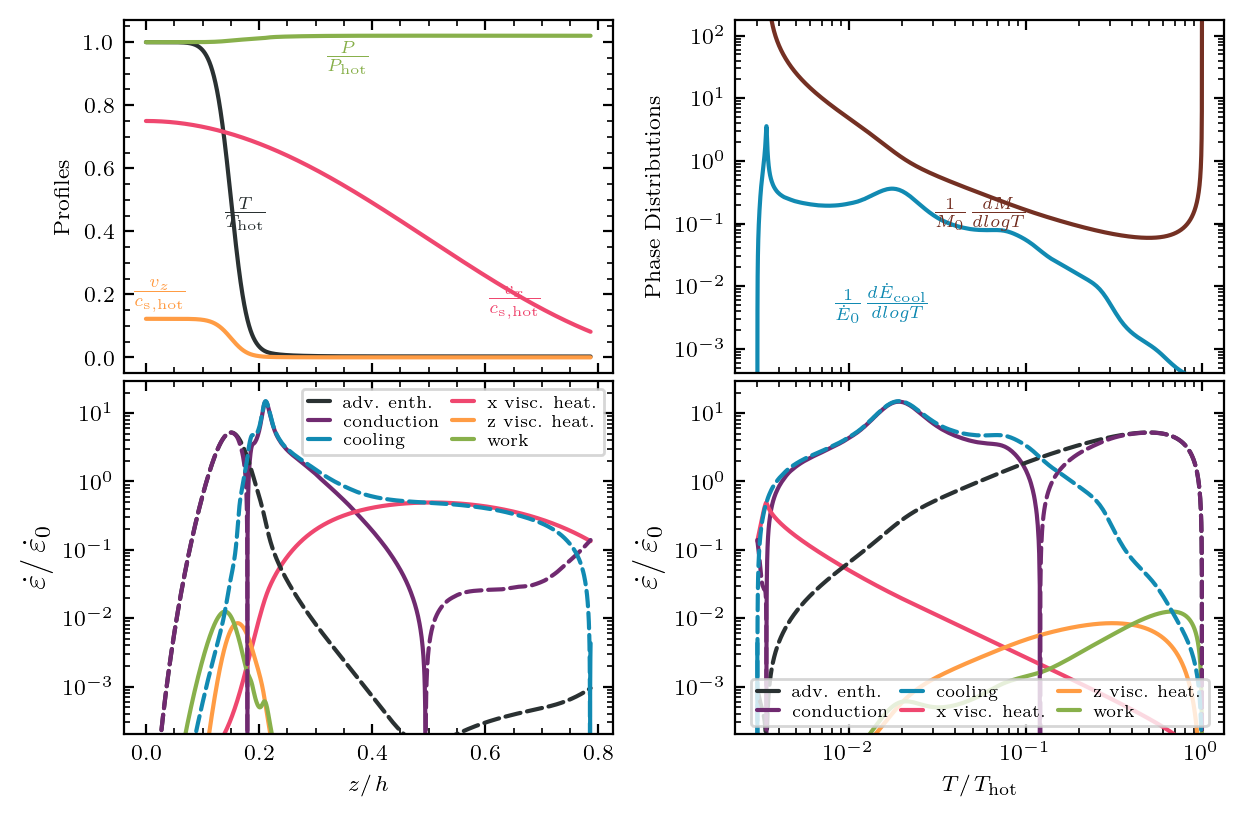

In [7]:
# we perform our bisection to find the eigenvalue of the mass flux mdot here
# our first guess for mdot is the maximum possible value mdot_crit, which corresponds to a vz_initial that is equal to c_s,hot
mdot_over_mdot_crit = 1.0
factor = 0.9
final_gradient = find_final_gradient(mdot_over_mdot_crit)
# we record the sign of the final T gradient of this solution, decrase our guess of mdot by 10%, and repeat this process
positive = 1
# we repeat the above procedure until the final T gradient changes sign
while positive > 0:
    mdot_over_mdot_crit *= factor
    next_final_gradient = find_final_gradient(mdot_over_mdot_crit)
    print(next_final_gradient)
    positive = next_final_gradient*final_gradient
    final_gradient = next_final_gradient
    
# now we know that the eigenvalue of mdot must be sandwiched between the two most recent guesses of mdot
# given this information, we can use scipy's root finder optimize.root_scalar to find the eigenvalue of mdot (mdot that corresponds to final T gradient=0)
# note that we set rtol and xtol to be very small here so that we can resolve the eigenvalue as accurately as possible
target = scipy.optimize.root_scalar(find_final_gradient, bracket = [mdot_over_mdot_crit,mdot_over_mdot_crit/factor], xtol=1e-14, rtol=1e-14)
sol = calculate_solution(target.root)

# finally we plot the solution we obtained using the pre-defined plotting function
plot_solution(sol,target.root)



# now that we have a 1D solution of TRML with the real cooling curve, we use the data from it to calculate column densities of ions

In [8]:
# enter the desired value of p_hot/kb, the fiducial value is 1000 K cm^(-3)
p_hot_over_kb = 1000

In [9]:
# solar abundances of elements, given as number of atoms per 1 hydrogen atom
solar_abundance = {
    'H' : 1.00e+00, 'He': 1.00e-01, 'Li': 2.04e-09,
    'Be': 2.63e-11, 'B' : 6.17e-10, 'C' : 2.45e-04,
    'N' : 8.51e-05, 'O' : 4.90e-04, 'F' : 3.02e-08,
    'Ne': 1.00e-04, 'Na': 2.14e-06, 'Mg': 3.47e-05,
    'Al': 2.95e-06, 'Si': 3.47e-05, 'P' : 3.20e-07,
    'S' : 1.84e-05, 'Cl': 1.91e-07, 'Ar': 2.51e-06,
    'K' : 1.32e-07, 'Ca': 2.29e-06, 'Sc': 1.48e-09,
    'Ti': 1.05e-07, 'V' : 1.00e-08, 'Cr': 4.68e-07,
    'Mn': 2.88e-07, 'Fe': 2.82e-05, 'Co': 8.32e-08,
    'Ni': 1.78e-06, 'Cu': 1.62e-08, 'Zn': 3.98e-08}

# atomic mass of elements in amu
atomic_mass = {
    'H' : 1.00794,   'He': 4.002602,  'Li': 6.941,
    'Be': 9.012182,  'B' : 10.811,    'C' : 12.0107,
    'N' : 14.0067,   'O' : 15.9994,   'F' : 18.9984032,
    'Ne': 20.1797,   'Na': 22.989770, 'Mg': 24.3050,
    'Al': 26.981538, 'Si': 28.0855,   'P' : 30.973761,
    'S' : 32.065,    'Cl': 35.453,    'Ar': 39.948,
    'K' : 39.0983,   'Ca': 40.078,    'Sc': 44.955910,
    'Ti': 47.867,    'V' : 50.9415,   'Cr': 51.9961,
    'Mn': 54.938049, 'Fe': 55.845,    'Co': 58.933200,
    'Ni': 58.6934,   'Cu': 63.546,    'Zn': 65.409}


def int_to_roman(integer):
    final_digit = integer % 10
    final_digit_roman = ''
    if (final_digit == 0):
        final_digit_roman = ''
    elif (final_digit == 1):
        final_digit_roman = 'I'
    elif (final_digit == 2):
        final_digit_roman = 'II'
    elif (final_digit == 3):
        final_digit_roman = 'III'
    elif (final_digit == 4):
        final_digit_roman = 'IV'
    elif (final_digit == 5):
        final_digit_roman = 'V'
    elif (final_digit == 6):
        final_digit_roman = 'VI'
    elif (final_digit == 7):
        final_digit_roman = 'VII'
    elif (final_digit == 8):
        final_digit_roman = 'VIII'
    elif (final_digit == 9):
        final_digit_roman = 'IX'
        
    tens_digit = int((integer - final_digit) / 10)
    
    tens_digit_roman = ''
    for i in range(tens_digit):
        tens_digit_roman = tens_digit_roman + 'X'
        
    return (tens_digit_roman + final_digit_roman)

In [10]:
# read in the ion fraction table from Haardt & Madau 2012
f = h5py.File('hm2012_hr.h5', 'r')

# interpolate between the ion fraction table for all ions
elements = [key for key in f.keys()]
log_nH_ionfraction = f[elements[0]].attrs['Parameter1']
redshift_ionfraction = f[elements[0]].attrs['Parameter2']
log_T_ionfraction = f[elements[0]].attrs['Temperature']

LogIonFractions = {}
for element in elements:
    n_ions = f[element].shape[0]
    for i in range(n_ions):
        LogIonFractions[element+str(i+1)] = interpolate.RegularGridInterpolator((log_nH_ionfraction, redshift_ionfraction, log_T_ionfraction),f[element][i],bounds_error=False, fill_value=0.0)
f.close()

In [17]:
j_eigen = target.root
z = sol.t
T = sol.y[1]
dT_dz = sol.y[0]
vz = sol.y[3]
rho = j_eigen/sol.y[3]

# read in data from the 1D solution with the real cooling curve
# remember that this data is still in code units, 
# we need to convert to cgs units before we can properly calculate physical quantities like column density
# The detailed procedure of how to do that can be found in our paper

pc_to_cm = 3.086e18



kb = 1.38e-16
mH = 1.66054e-24 # in grams
gamma = 5.0/3
P_hot = p_hot_over_kb*kb
rho_hot = (P_hot / T_hot_in_K) / (kb / (0.61*mH))
L_0 = 378.4*(tau/10**(-1.5))**(-1)*(p_hot_over_kb/1000)**(-1)*(T_hot_in_K/10**6)**0.5*pc_to_cm
cs_hot = math.sqrt(gamma*P_hot / rho_hot)

gram_to_msun = 5.02785e-34

# take arrays of distance, temperature, pressure from the 1D solution, and calculate number density
# sol.t is the array of positions
# sol.y[1] is the array of temperatures
# target.root is the eigenvalue of the mass flux mdot
# sol.y[3] is the array of z velocities
zs           = 378.4*(tau/10**(-1.5))**(-1)*(p_hot_over_kb/1000)**(-1)*(T_hot_in_K/10**6)**0.5*pc_to_cm*z
Ts           = T_hot_in_K*T # T_hot=1e6K
Ps           = p_hot_over_kb*(T*rho)# P/kb=1000 at the hot phase
ns = Ps/Ts


# take arrays of the mass and cooling distributions and convert to physical units
M_0 = rho_hot*L_0**3*gram_to_msun
Edot_0 = rho_hot*cs_hot**3*L_0**2

dEdot_dlogT_in_code_units = (T/-dT_dz)*edot_cool_double_equilibrium(T)
dM_dlogT_in_code_units    = (T/-dT_dz)*(rho)

dM_dlogT    = M_0*dM_dlogT_in_code_units # in solar masses
dEdot_dlogT = Edot_0*dEdot_dlogT_in_code_units # in erg/s

# convert mass distribution to column density distribution by dividing through by L_0**2*mH
dSigma_dlogT = (dM_dlogT / L_0**2)
dN_dlogT = dSigma_dlogT / (mH*gram_to_msun)
# convert cooling distribution to cooling flux distribution by dividing through by L_0**2
dFcool_dlogT = dEdot_dlogT / L_0**2

In [18]:
# list out the ions that you want to plot the ion fraction and column densities of as a dictionary
# for example, if you are interested in NV and OVI, then the dictionary should look like:
# ions_of_interest = {'N': [5], 'O':[6]}
# if you are interested in more than one ion of the same element, simply enter more than one number in the corresponding list
# for example, if you are interested in OVI and OVII, then the dictionary should look like:
# ions_of_interest = {'O':[6, 7]}

ions_of_interest = {'Mg':[2], 'Si':[3], 'C':[4], 'N':[5], 'O':[6, 7], 'Ne':[8]}
#ions_of_interest = {'O':[1, 2, 3, 4, 5, 6, 7, 8]}


In [19]:
total_ion_count = 0
for i in solar_abundance:
    total_ion_count += solar_abundance[i]

# calculate ion fractions and column densities

elements = []
ionizations = []
ion_fractions = []
column_densities = []


for i in ions_of_interest:
    for j in range(len(ions_of_interest[i])):
        n_of_element = ns*(solar_abundance[i] / (total_ion_count)) # number density of the element of interest (all ions combined)
        fraction_of_ion = 10**LogIonFractions[i+str(ions_of_interest[i][j])]((np.log10(Ps/Ts),0,np.log10(Ts))) # fraction of the ion of interest
        n_of_ion = fraction_of_ion*n_of_element # calculate number density of the ion using the two previous results
        column_density_of_ion = integrate.simps(n_of_ion, zs) # calculate column density by integrating across the mixing layer
        elements.append(i)
        ionizations.append(ions_of_interest[i][j])
        ion_fractions.append(fraction_of_ion)
        column_densities.append(column_density_of_ion)

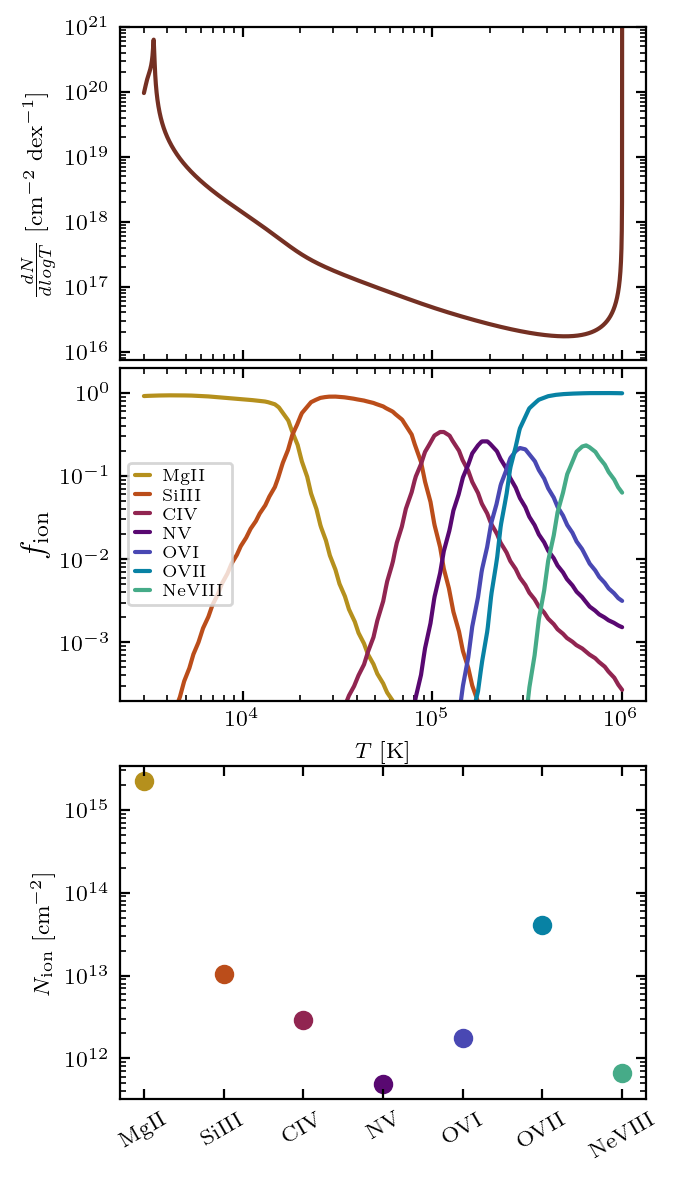

In [20]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})


gridspec = dict(hspace=0.03, height_ratios=[1, 1, 0.15, 1])
fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(4,1, gridspec_kw=gridspec)

ax3.set_visible(False)



ax1.loglog(Ts,  dN_dlogT, color='#743023')



ax1.set_ylim(top=1e21)
ax1.set_ylabel(r'$\frac{d N}{d logT}$ $[{\rm cm}^{-2}$ ${\rm dex}^{-1}] $', fontsize=8)


plt.setp(ax1.get_xminorticklabels(), visible=False)
plt.setp(ax1.get_xmajorticklabels(), visible=False)



ion_colors = cmr.take_cmap_colors('cmr.infinity_s', len(column_densities), cmap_range=(0.1, 0.9), return_fmt='hex')


for i in range(len(column_densities)):
    ax2.loglog(Ts, ion_fractions[i], color=ion_colors[i], label=elements[i]+str(int_to_roman(ionizations[i])))
ax2.set_ylabel(r'$f_{\rm ion}$')
ax2.set_xlabel(r'$T$ $[{\rm K}]$', fontsize=8)

ax2.set_ylim(2e-4,2)
ax2.legend(loc='best', ncol = 1, fontsize=6, handlelength=0.9, labelspacing=0.25, columnspacing=0.7)




ion_ids = []
for i in range(len(column_densities)):
    ion_ids.append(elements[i]+str(int_to_roman(ionizations[i])))

for i in range(len(column_densities)):
    ax4.scatter(i, column_densities[i], marker='o', color=ion_colors[i])

ax4.xaxis.set_ticks(np.arange(len(column_densities)))
ax4.xaxis.set_ticklabels(ion_ids, rotation=30)
ax4.set_ylabel(r'$N_{\rm ion}$ $[{\rm cm}^{-2}]$', fontsize=8)
ax4.set_yscale('log')



ax1.tick_params(axis='both', labelsize=8)
ax2.tick_params(axis='both', labelsize=8)
ax4.tick_params(axis='both', labelsize=8)


ax4.tick_params(axis='x', which='minor', bottom=False)
ax4.tick_params(axis='x', which='minor', top=False)
ax4.tick_params(axis='y', which='minor', left=True)
ax4.tick_params(axis='y', which='minor', right=True)



fig.set_size_inches(3.39375, 7.1)



#plt.savefig('ion fraction and column density.pdf', dpi=200, bbox_inches='tight')
plt.show()
plt.close('all')